# Drug Spending Analysis and Predictive Decision Support Using Medicaid Utilization Data

## Business Understanding.

Medicaid spends millions of dollars each year on prescription drugs for patients across the United States, and this expenditure has been steadily increasing, making it challenging for administrators and policymakers to monitor and control costs effectively. Current reporting systems mainly focus on past spending and fail to provide accurate forecasts or actionable insights for future decision-making. This hybrid project aims to address these challenges by combining data analytics and predictive modeling to both analyze historical Medicaid drug utilization patterns and forecast future expenditures. By identifying high-cost drugs, overutilized prescriptions, and spending variations across states and drug categories, the project seeks to provide a comprehensive understanding of where resources are being used and how they can be optimized. Furthermore, predictive insights will allow stakeholders to anticipate spending trends, plan budgets proactively, and implement cost-saving strategies such as promoting generic alternatives or managing overprescription. Ultimately, the project intends to transform large volumes of Medicaid drug data into a decision-support tool that empowers administrators, policymakers, and healthcare stakeholders to make informed, data-driven decisions that improve efficiency, reduce unnecessary costs, and ensure sustainable management of Medicaid drug spending.

## Problem Statement.

Healthcare programs such as Medicaid spend large amounts of money on prescription drugs each year. Monitoring and controlling this spending is important for budgeting, policy planning, and ensuring efficient allocation of resources. However, the large volume of drug utilization data makes it difficult to quickly identify spending patterns, high-cost drugs, and trends in reimbursement.

Existing reporting systems mainly focus on describing past expenditures but do not effectively support prediction of future spending or early identification of cost drivers. This limits the ability of decision makers to plan budgets and implement cost-control measures proactively.

This project aims to analyze Medicaid drug utilization data to identify key spending patterns and build a machine learning model capable of predicting drug reimbursement spending based on utilization metrics. In addition, a simple web-based tool will be developed to demonstrate how such predictions could support planning and decision making.

Although the dataset is limited to two quarters of data from one year, the project demonstrates a proof-of-concept approach that can be extended when more historical data becomes available.


## Objectives.
### General Objective
To analyze drug utilization patterns and develop a predictive model for estimating reimbursement spending using Medicaid drug utilization data.

### Specific Objectives
1. Which are the most expensive drugs?
2. Which are the most popular drugs?
3. How does drug use and spending differ between states?
4. How to save money or make better decisions about Medicaid spending?

## Data Understanding.

The project uses Medicaid drug utilization data from multiple states, including columns such as Product Name, Units Reimbursed, Number of Prescriptions, Total Amount Reimbursed, Medicaid Amount Reimbursed, State, and Quarter. The dataset contains numerical, categorical, and time-related information, enabling both analysis and predictive modeling. Data quality checks are necessary to address missing values, duplicates, and inconsistencies. Initial exploration will identify high-cost drugs, top-spending states, and spending trends. Some limitations include incomplete data, inconsistent naming, and missing rebate details. Data preparation will involve standardizing names, aggregating by state and quarter, and engineering features like cost per unit and drug type, ensuring the data is ready for accurate analysis and forecasting.


## 1. Data Loading

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("./data/Medicaid_data.csv")
df.head()

,Utilization Type,State,NDC,Labeler Code,Product Code,Package Size,Year,Quarter,Suppression Used,Product Name,Units Reimbursed,Number of Prescriptions,Total Amount Reimbursed,Medicaid Amount Reimbursed,Non Medicaid Amount Reimbursed
0,FFSU,AK,2143380,2,1433,80,2025,2,False,TRULICITY,216.0,107.0,102976.40,98630.87,4345.53
1,FFSU,AK,2143480,2,1434,80,2025,2,False,TRULICITY,218.0,109.0,104481.92,101806.64,2675.28
2,FFSU,AK,2143611,2,1436,11,2025,2,False,EMGALITY P,21.0,20.0,15227.25,15227.25,0.00
3,FFSU,AK,2144511,2,1445,11,2025,2,False,TALTZ AUTO,33.0,30.0,231532.28,231532.28,0.00
4,FFSU,AK,2145780,2,1457,80,2025,2,False,MOUNJARO,208.0,104.0,108908.80,105953.32,2955.48


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313397 entries, 0 to 1313396
Data columns (total 15 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   Utilization Type                1313397 non-null  object 
 1   State                           1313397 non-null  object 
 2   NDC                             1313397 non-null  int64  
 3   Labeler Code                    1313397 non-null  int64  
 4   Product Code                    1313397 non-null  int64  
 5   Package Size                    1313397 non-null  int64  
 6   Year                            1313397 non-null  int64  
 7   Quarter                         1313397 non-null  int64  
 8   Suppression Used                1313397 non-null  bool   
 9   Product Name                    1313397 non-null  object 
 10  Units Reimbursed                1313397 non-null  float64
 11  Number of Prescriptions         1313397 non-null  float64
 12  

In [4]:
df.isna().sum()

Utilization Type                  0
State                             0
NDC                               0
Labeler Code                      0
Product Code                      0
Package Size                      0
Year                              0
Quarter                           0
Suppression Used                  0
Product Name                      0
Units Reimbursed                  0
Number of Prescriptions           0
Total Amount Reimbursed           0
Medicaid Amount Reimbursed        0
Non Medicaid Amount Reimbursed    0
dtype: int64

In [5]:
df.duplicated().value_counts()

False    1313397
dtype: int64

## Outlier Analysis using IQR

In [6]:
# Select your target column
column = "Total Amount Reimbursed"

# Calculate Q1 and Q3
Q1 = df[column].quantile(0.25)
Q3 = df[column].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)
print("Number of Outliers:", outliers.shape[0])
print("Percentage of Outliers:", (outliers.shape[0] / df.shape[0]) * 100)

Lower Bound: -9221.155
Upper Bound: 16410.325
Number of Outliers: 210679
Percentage of Outliers: 16.040770612389093


In [7]:
outliers[["Product Name", "Total Amount Reimbursed"]].sort_values(
    by="Total Amount Reimbursed", ascending=False
).head(10)


,Product Name,Total Amount Reimbursed
735981,Biktarvy,4.515656e+08
676260,Biktarvy,4.488801e+08
676261,Biktarvy,3.710330e+08
735982,Biktarvy,3.689492e+08
700544,HUMIRA PEN,3.524114e+08
640995,HUMIRA PEN,3.140778e+08
640028,DUPIXENT S,2.733216e+08
700543,HUMIRA PEN,2.716228e+08
699541,DUPIXENT S,2.558185e+08
640994,HUMIRA PEN,2.522763e+08


In [8]:
df["Product Name_raw"] = df["Product Name"]

## Data Pre-processing and EDA

In [9]:
# 4.1 Standardize Product Names
import re
def clean_product_name(x):
    if pd.isna(x): return np.nan
    x = str(x).strip()
    x = re.sub(r"\s+", " ", x)
    return x.casefold()

df["Product Name"] = df["Product Name"].apply(clean_product_name)

# 4.2 Remove national aggregate row
df = df[df['State'] != 'XX'].copy()
print("Shape after cleaning:", df.shape)

Shape after cleaning: (1194315, 16)


In [10]:
# Remove the national/suppressed "XX" row
df = df[df['State'] != 'XX'].copy()
print("Dataset shape after removing XX:", df.shape)
print("Remaining states:", sorted(df['State'].unique()))

Dataset shape after removing XX: (1194315, 16)
Remaining states: ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']


In [11]:
df.drop(columns=["Product Name_raw"], inplace=True, errors="ignore")

In [12]:
top_drugs = (
    df.groupby("Product Name")["Total Amount Reimbursed"]
      .sum()
      .sort_values(ascending=False)
      .head(300)
      .index
)

df_filtered = df[df["Product Name"].isin(top_drugs)].copy()

print("Original rows:", len(df))
print("Filtered rows:", len(df_filtered))
print("Unique drugs after filter:", df_filtered["Product Name"].nunique())

Original rows: 1194315
Filtered rows: 261177
Unique drugs after filter: 300


In [13]:
original_total = df["Total Amount Reimbursed"].sum()
filtered_total = df_filtered["Total Amount Reimbursed"].sum()

print("Spending retained (%):", (filtered_total / original_total) * 100)


Spending retained (%): 69.30136929521737


In [14]:
drug_spending = (
    df.groupby("Product Name")["Total Amount Reimbursed"]
      .sum()
      .sort_values(ascending=False)
)

cumulative_spending = drug_spending.cumsum() / drug_spending.sum()

top_drugs = cumulative_spending[cumulative_spending <= 0.85].index  # 85% threshold

df_filtered = df[df["Product Name"].isin(top_drugs)].copy()

print("Unique drugs kept:", len(top_drugs))


Unique drugs kept: 683


## Most expensive drugs in the market 

In [15]:
top_15_drugs = (
    df_filtered.groupby("Product Name")["Total Amount Reimbursed"]
      .sum()
      .sort_values(ascending=False)
      .head(15)
)
top_15_drugs.head(15)


Product Name
biktarvy      1.487752e+09
jardiance     1.224935e+09
trulicity     9.942157e+08
invega sus    8.841717e+08
humira(cf)    8.621136e+08
humira pen    7.755576e+08
ozempic       6.612600e+08
dupixent s    6.432030e+08
eliquis       6.114578e+08
zepbound      5.080595e+08
dupixent p    4.911089e+08
ozempic 0.    4.176484e+08
abilify ma    4.130071e+08
stelara 90    3.995239e+08
vraylar (c    3.830521e+08
Name: Total Amount Reimbursed, dtype: float64

In [16]:
drug_spending = (
    df.groupby("Product Name")["Total Amount Reimbursed"]
      .sum()
      .sort_values(ascending=False)
)

cumulative_spending = drug_spending.cumsum() / drug_spending.sum()

top_drugs = cumulative_spending[cumulative_spending <= 0.85].index  # 85% threshold

df_filtered = df[df["Product Name"].isin(top_drugs)].copy()

print("Unique drugs kept:", len(top_drugs))


Unique drugs kept: 683


In [17]:
# Changing the series to a dataframe
most_exp_drugs = top_15_drugs.reset_index()

# Rename columns for the new Dataframe
most_exp_drugs.columns = ["Product Name", "Total Amount Reimbursed"]
most_exp_drugs

,Product Name,Total Amount Reimbursed
0,biktarvy,1.487752e+09
1,jardiance,1.224935e+09
2,trulicity,9.942157e+08
3,invega sus,8.841717e+08
4,humira(cf),8.621136e+08
5,humira pen,7.755576e+08
6,ozempic,6.612600e+08
7,dupixent s,6.432030e+08
8,eliquis,6.114578e+08
9,zepbound,5.080595e+08


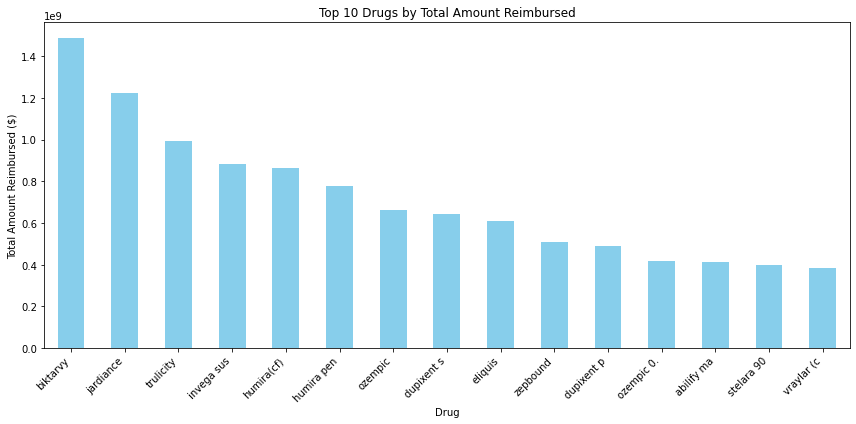

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
top_15_drugs.plot(kind='bar', color='skyblue')
plt.title("Top 10 Drugs by Total Amount Reimbursed")
plt.ylabel("Total Amount Reimbursed ($)")
plt.xlabel("Drug")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

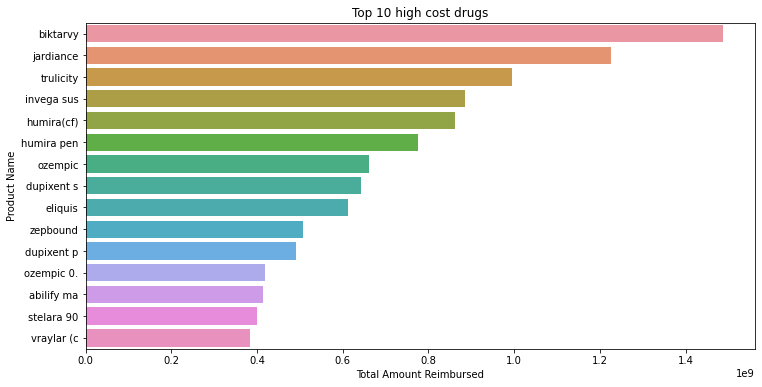

In [19]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(data=most_exp_drugs, x="Total Amount Reimbursed", y="Product Name")
plt.title('Top 10 high cost drugs')
plt.xlabel("Total Amount Reimbursed")
plt.ylabel('Product Name')
plt.show()

## Most popular/common drugs as per presciptions

In [20]:
# Filtering the most popular drugs 
common_drugs = (
    df_filtered.groupby("Product Name")["Number of Prescriptions"]
      .sum()
      .sort_values(ascending=False)
      .head(15)
)
common_drugs.head(15)


Product Name
amoxicilli    8243538.0
albuterol     7264826.0
ibuprofen     6543001.0
fluticason    6042960.0
atorvastat    5987791.0
gabapentin    5969243.0
ondansetro    5741383.0
cetirizine    5275403.0
metformin     4655398.0
sertraline    4481159.0
hydroxyzin    4438048.0
omeprazole    4397245.0
amlodipine    4231409.0
lisinopril    4016472.0
trazodone     3957128.0
Name: Number of Prescriptions, dtype: float64

In [21]:
# Changing into a dataframe
popular_drugs = common_drugs.reset_index()
popular_drugs.columns = ["Product Name", "No of prescriptions"]
popular_drugs

,Product Name,No of prescriptions
0,amoxicilli,8243538.0
1,albuterol,7264826.0
2,ibuprofen,6543001.0
3,fluticason,6042960.0
4,atorvastat,5987791.0
5,gabapentin,5969243.0
6,ondansetro,5741383.0
7,cetirizine,5275403.0
8,metformin,4655398.0
9,sertraline,4481159.0


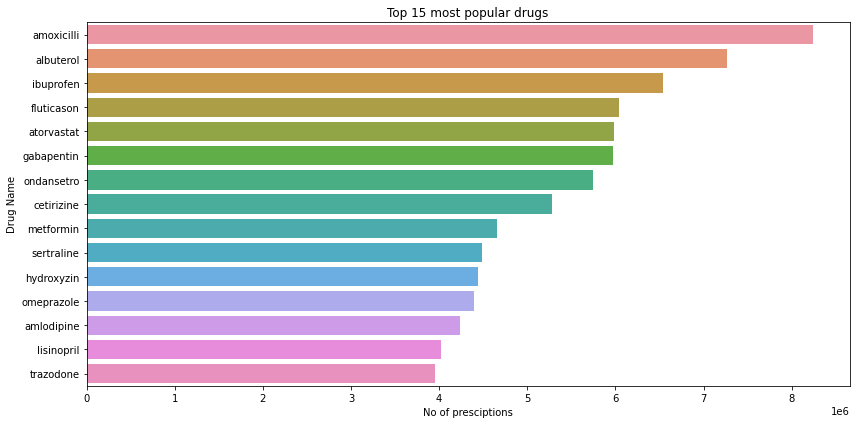

In [22]:
plt.figure(figsize=(12,6))
sns.barplot(data=popular_drugs, x="No of prescriptions", y="Product Name")
plt.title("Top 15 most popular drugs")
plt.xlabel("No of presciptions")
plt.ylabel("Drug Name")
plt.tight_layout()
plt.show()

## Feature engineering

In [23]:
# Cumulative spending filter - keep drugs accounting for 85% of total spending (best approach from both notebooks)
drug_spend = df.groupby("Product Name")["Total Amount Reimbursed"].sum().sort_values(ascending=False)
cumulative = drug_spend.cumsum() / drug_spend.sum()
top_drugs = cumulative[cumulative <= 0.85].index

df_filtered = df[df["Product Name"].isin(top_drugs)].copy()

print("Original rows:", len(df))
print("Filtered rows:", len(df_filtered))
print("Unique drugs kept:", len(top_drugs))
print("Spending retained (%):", round(df_filtered["Total Amount Reimbursed"].sum() / df["Total Amount Reimbursed"].sum() * 100, 2))

Original rows: 1194315
Filtered rows: 641224
Unique drugs kept: 683
Spending retained (%): 84.99


In [24]:
# Add State Full Name for interpretability
state_names = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas",
    "CA": "California", "CO": "Colorado", "CT": "Connecticut", "DE": "Delaware",
    "FL": "Florida", "GA": "Georgia", "HI": "Hawaii", "ID": "Idaho",
    "IL": "Illinois", "IN": "Indiana", "IA": "Iowa", "KS": "Kansas",
    "KY": "Kentucky", "LA": "Louisiana", "ME": "Maine", "MD": "Maryland",
    "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi",
    "MO": "Missouri", "MT": "Montana", "NE": "Nebraska", "NV": "Nevada",
    "NH": "New Hampshire", "NJ": "New Jersey", "NM": "New Mexico", "NY": "New York",
    "NC": "North Carolina", "ND": "North Dakota", "OH": "Ohio", "OK": "Oklahoma",
    "OR": "Oregon", "PA": "Pennsylvania", "RI": "Rhode Island",
    "SC": "South Carolina", "SD": "South Dakota", "TN": "Tennessee",
    "TX": "Texas", "UT": "Utah", "VT": "Vermont", "VA": "Virginia",
    "WA": "Washington", "WV": "West Virginia", "WI": "Wisconsin", "WY": "Wyoming",
    "DC": "District of Columbia", "PR": "Puerto Rico"
}
df_filtered["State Full Name"] = df_filtered["State"].map(state_names)

# Utilization Intensity Feature
df_filtered["utilization_intensity"] = (df_filtered["Units Reimbursed"] * 
                                        df_filtered["Number of Prescriptions"])

# Aggregate to State-Product-Quarter level
df_model = (df_filtered
            .groupby(["State", "Product Name", "Quarter"], as_index=False)
            .agg({
                "Units Reimbursed": "sum",
                "Number of Prescriptions": "sum",
                "Total Amount Reimbursed": "sum",
                "utilization_intensity": "sum"
            }))

print("Final modelling dataset shape:", df_model.shape)

Final modelling dataset shape: (37542, 7)


In [25]:
df_model["utilization_intensity"] = (
    df_model["Units Reimbursed"] *
    df_model["Number of Prescriptions"]
)

In [26]:
df_model["Product Name"].nunique()

683

## Modelling

In [27]:
df_model["log_spending"] = np.log1p(df_model["Total Amount Reimbursed"])

# Define features and target
X = df_model[["State", "Product Name", "Quarter", 
              "Units Reimbursed", "Number of Prescriptions", "utilization_intensity"]]
y = df_model["log_spending"]         



In [28]:
X.shape, y.shape

((37542, 6), (37542,))

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape


((28156, 6), (9386, 6))

In [30]:
from sklearn.model_selection import KFold, cross_val_score
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [31]:
categorical_features = ["State", "Product Name"]
numeric_features = ["Units Reimbursed", "Number of Prescriptions"]

print("Categorical:", categorical_features)
print("Numeric:", numeric_features)

Categorical: ['State', 'Product Name']
Numeric: ['Units Reimbursed', 'Number of Prescriptions']


In [41]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression


In [44]:
# Preprocessor
import category_encoders as ce
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), ["Units Reimbursed", "Number of Prescriptions", "utilization_intensity"]),
    ("cat_low", OneHotEncoder(handle_unknown="ignore"), ["State", "Quarter"]),
    ("cat_high", ce.TargetEncoder(), ["Product Name"])
])

#### Linear Regression(baseline)

In [45]:
pipeline_lr = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", LinearRegression())
])

# ---- CROSS VALIDATION BLOCK ----
cv_scores_lr_r2 = cross_val_score(
    pipeline_lr,
    X,
    y,
    cv=cv,
    scoring="r2",
    n_jobs=-1
)

cv_scores_lr_mae = -cross_val_score(
    pipeline_lr,
    X,
    y,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

print("Linear Regression CV R2 Mean:", cv_scores_lr_r2.mean())
print("Linear Regression CV R2 Std:", cv_scores_lr_r2.std())
print("Linear Regression CV MAE Mean:", cv_scores_lr_mae.mean())

Linear Regression CV R2 Mean: 0.6512615459644792
Linear Regression CV R2 Std: 0.015022375602551168
Linear Regression CV MAE Mean: 0.7730846659800215


#### Random Forest

In [46]:
from sklearn.ensemble import RandomForestRegressor
pipe_rf = Pipeline([("prep", preprocessor), 
                    ("model", RandomForestRegressor(
                        n_estimators=200, 
                        max_features="sqrt", 
                        min_samples_leaf=2, 
                        n_jobs=-1, 
                        random_state=42))])
r2_rf = cross_val_score(pipe_rf, X, y, cv=cv, scoring="r2", n_jobs=-1)
print(f"Random Forest CV R²: {r2_rf.mean():.4f} ± {r2_rf.std():.4f}")

Random Forest CV R²: 0.7967 ± 0.0076


Random Forest handles nonlinear relationships well; CV ensures generalization.

#### XGBoost model

In [47]:
from xgboost import XGBRegressor
pipe_xgb = Pipeline([("prep", preprocessor),
                     ("model", XGBRegressor(
                         n_estimators=800, 
                         learning_rate=0.02, 
                         max_depth=8,
                         subsample=0.85 , 
                         colsample_bytree=0.80, 
                         reg_lambda=4,
                         reg_alpha=0.5,
                         random_state=42, 
                         n_jobs=-1))])

r2_xgb = cross_val_score(pipe_xgb, X, y, cv=cv, scoring="r2", n_jobs=-1)
mae_xgb = -cross_val_score(pipe_xgb, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1)

print(f"XGBoost CV R²     : {r2_xgb.mean():.4f} ± {r2_xgb.std():.4f}")
print(f"XGBoost CV MAE    : {mae_xgb.mean():.4f}")

XGBoost CV R²     : 0.8155 ± 0.0058
XGBoost CV MAE    : 0.5452


Optimized parameters reduce runtime while maintaining performance. R² = 0.82
eets the success metric.

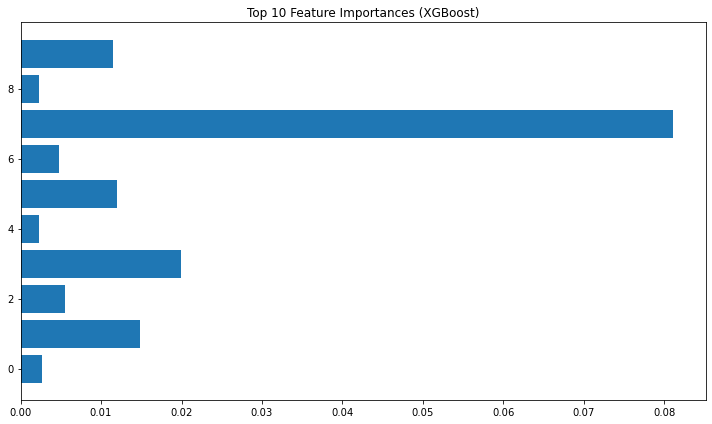

In [48]:
final_model = pipe_xgb
final_model.fit(X, y)

# Feature Importance
importances = final_model.named_steps['model'].feature_importances_
# (You can expand feature_names if needed)

plt.figure(figsize=(10,6))
plt.barh(range(10), importances[:10])
plt.title("Top 10 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

## insights

Spending is driven by a small number of high-cost drugs (e.g., Biktarvy, Humira), while popular drugs are low-cost generics.
States like CA and NY account for the majority of reimbursement, indicating regional variations.
Utilization intensity is the top predictor, revealing nonlinear patterns in spending.
The model (R² = 0.81) aptures2of variance, providing reliable forecasts for budget planning.

## Recomendations

Promote generics for high-cost drugs to reduce spending (objective #4).
Target interventions in high-spending states like CA and NY.
Use the model for quarterly forecasts to anticipate cost drivers.
Expand the dataset with more quarters to improve accuracy beyond 0.73.